# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-besra'
epochs = 10
batch_size = 4
sequence_length = 192

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctor-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [10]:
get_dataloaders(X_train, y_train, X_val, y_val)

(<torch.utils.data.dataloader.DataLoader at 0x78dce6ce6e60>,
 <torch.utils.data.dataloader.DataLoader at 0x78dce6ce7160>)

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    # class_probs = labeled_dataset.get_per_class_probs() 
    # label_probs = labeled_dataset.get_global_probs() 
    
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = DoctorAnswerDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        # all_probs = []
        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))

    # Perform K-means clustering
    collected_indices = set()  # Initialize set to store selected indices
    
    accelerator.wait_for_everyone()
    
    if accelerator.is_local_main_process:
        num_of_candidates = len(score_changes[:math.ceil(0.1 * len(score_changes))])
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of clusters
        if num_of_candidates <= n_clusters and n_clusters < nearest_cp - current_train_size:
            n_clusters = n_clusters
        elif num_of_candidates > n_clusters and num_of_candidates < nearest_cp - current_train_size:
            n_clusters = num_of_candidates
        else:
            arrived_at_cp = True
            n_clusters = nearest_cp - current_train_size

        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)
            
        kmeans=KMeans(n_clusters=n_clusters, n_init=1)
        kmeans.fit(score_changes)

        if current_train_size > checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]  # Indices of samples in the current cluster
                
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances to the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
                closest_sample_index = cluster_indices[np.argmin(cluster_distances)]  # Closest sample index
                collected_indices.add(closest_sample_index)

            end_time = time.time() 
            duration = end_time - start_time 
            
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    '1-FR': [y_train[i][0] for i in temp],
                    '2-GI': [y_train[i][1] for i in temp],
                    '3-PI': [y_train[i][2] for i in temp],
                    '4-DM': [y_train[i][3] for i in temp],
                    '5-EDTRB': [y_train[i][4] for i in temp],
                    '6-RE': [y_train[i][5] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 7, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5938, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3975, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2793, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2125, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2185, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1651, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2094, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1328, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.638, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4006, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.296, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2339, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2346, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1755, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1383, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5657, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3775, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2018, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2273, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.156, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2098, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1346, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5014, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1349, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.126, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1426, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4709, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2373, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1207, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1453, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4131, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2118, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1392, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1472, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1239, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6509
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Epoch 10/10, Train Loss: 0.0762, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4368, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2259, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1364, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1193, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.0825, Accuracy: 0.9599, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2086, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1416, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.148, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1379, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1147, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.9615, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3735, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1806, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.1007, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Epoch 10/10, Train Loss: 0.061, Accuracy: 0.9615, F1 Micro: 0.9709, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3992, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1895, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1478, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Epoch 7/10, Train Loss: 0.1202, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.1119, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0871, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6517
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.9583, F1 Micro: 0.9682, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3559, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1774, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 9/10, Train Loss: 0.0946, Accuracy: 0.9631, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3789, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1866, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.702
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1907, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1518, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6514
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6523
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 10/10, Train Loss: 0.0442, Accuracy: 0.9599, F1 Micro: 0.9694, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3513, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1839, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1469, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7639
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6505
Epoch 10/10, Train Loss: 0.0439, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.313, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7655
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.791
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7963
Epoch 10/10, Train Loss: 0.0427, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3309, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1938, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.72
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.7044
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7484
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2941, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.193, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1527, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7101
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7543
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9519, F1 Micro: 0.9628, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9696, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3093, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1978, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 10/10, Train Loss: 0.0374, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3293, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2052, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2987, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2021, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7189
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7774
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0388, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3114, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1777, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7441
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7532
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1832, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7921
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7189
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.9663, F1 Micro: 0.9744, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3018, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1793, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9535, F1 Micro: 0.9642, F1 Macro: 0.7561
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 10/10, Train Loss: 0.0484, Accuracy: 0.9663, F1 Micro: 0.9742, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3139, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1931, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1636, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7384
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7782
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0441, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3281, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.194, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1669, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0913, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7431
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7394
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3031, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1938, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1657, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.304, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1864, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3203, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1902, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1793, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7633
Epoch 10/10, Train Loss: 0.0383, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2956, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1901, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9744, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2986, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2004, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0446, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3189, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2036, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1832, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.089, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7921
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2974, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2044, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9728, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3022, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2105, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2129, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7808
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.976, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2929, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2114, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1928, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7473
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.752
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.297, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1853, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.761
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9647, F1 Micro: 0.973, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3107, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1891, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7929
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7478
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7882
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2885, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1867, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2975, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1912, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7493
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7655
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3085, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.0392, Accuracy: 0.9712, F1 Micro: 0.9781, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2867, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9728, F1 Micro: 0.9793, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2698, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7931
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7469
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2844, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1929, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1772, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9599, F1 Micro: 0.9699, F1 Macro: 0.7345
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7569
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9696, F1 Micro: 0.9769, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2597, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1923, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0796, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9744, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.273, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1826, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1447, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Epoch 5/10, Train Loss: 0.1089, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.082, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7393
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7552
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2888, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1863, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1442, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7568
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.9696, F1 Micro: 0.9768, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.184, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7513
Epoch 5/10, Train Loss: 0.1093, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.747
Epoch 6/10, Train Loss: 0.0795, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8033
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2771, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1919, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7595
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.9696, F1 Micro: 0.9769, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2865, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1924, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1799, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7513
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7394
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9599, F1 Micro: 0.9699, F1 Macro: 0.7394
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7521
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.9679, F1 Micro: 0.9757, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2651, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1903, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Epoch 7/10, Train Loss: 0.0603, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 8/10, Train Loss: 0.0402, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9712, F1 Micro: 0.978, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1824, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7548
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7497
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0302, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2836, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8033
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.8204
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7969
Epoch 8/10, Train Loss: 0.0368, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.9728, F1 Micro: 0.9793, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1818, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1067, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0771, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0351, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2786, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1827, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.775
Epoch 6/10, Train Loss: 0.0713, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7494
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Model 1 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2929, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1832, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1797, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 6/10, Train Loss: 0.0683, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7521
Epoch 7/10, Train Loss: 0.0495, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0493, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7585
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7902
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0336, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2717, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 6/10, Train Loss: 0.0673, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0472, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7864
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.9114
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2633, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1848, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1326, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1051, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0772, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0524, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7429
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0269, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1878, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1543, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1405, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8012
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0782, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 7/10, Train Loss: 0.0558, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7487
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2512, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1883, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1537, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1386, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1077, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8226
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2469, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1505, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1273, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0955, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 6/10, Train Loss: 0.0589, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Epoch 7/10, Train Loss: 0.0546, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.753
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7521
Epoch 9/10, Train Loss: 0.0319, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7569
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9696, F1 Micro: 0.9769, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2546, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.099, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0526, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0317, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7521
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.7416
Epoch 10/10, Train Loss: 0.0293, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2395, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1533, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1355, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0969, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0591, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7459
Epoch 8/10, Train Loss: 0.034, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0304, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2451, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1566, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1476, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1323, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 6/10, Train Loss: 0.072, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.0568, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7469
Epoch 8/10, Train Loss: 0.0364, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Epoch 10/10, Train Loss: 0.0225, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2573, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1586, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0695, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0557, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7988
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7491
Epoch 10/10, Train Loss: 0.0233, Accuracy: 0.9631, F1 Micro: 0.9721, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2402, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1568, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1571, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.0716, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0349, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7402
Epoch 10/10, Train Loss: 0.0245, Accuracy: 0.9647, F1 Micro: 0.9733, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2541, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1815, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1576, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 4/10, Train Loss: 0.1293, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1005, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0733, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0475, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 8/10, Train Loss: 0.0357, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0323, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7576
Epoch 10/10, Train Loss: 0.0223, Accuracy: 0.9583, F1 Micro: 0.9686, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2576, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1587, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1068, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7937
Epoch 7/10, Train Loss: 0.0455, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0337, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0239, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2458, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1811, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.155, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 4/10, Train Loss: 0.1284, Accuracy: 0.9583, F1 Micro: 0.9688, F1 Macro: 0.7293
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.0691, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0433, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7546
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9535, F1 Micro: 0.9649, F1 Macro: 0.7788
Epoch 10/10, Train Loss: 0.0209, Accuracy: 0.9663, F1 Micro: 0.9744, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2515, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1633, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1394, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 5/10, Train Loss: 0.0906, Accuracy: 0.9567, F1 Micro: 0.9664, F1 Macro: 0.7571
Epoch 6/10, Train Loss: 0.0654, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0472, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 8/10, Train Loss: 0.0323, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.025, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2584, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1655, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1458, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7883
Epoch 6/10, Train Loss: 0.063, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Epoch 8/10, Train Loss: 0.028, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7782
Model 2 - Iteration 40

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2411, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1651, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1402, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 4/10, Train Loss: 0.1341, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7395
Epoch 5/10, Train Loss: 0.0889, Accuracy: 0.9583, F1 Micro: 0.9674, F1 Macro: 0.7875
Epoch 6/10, Train Loss: 0.0551, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0447, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0279, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0238, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7551
Model 3 - Iteratio

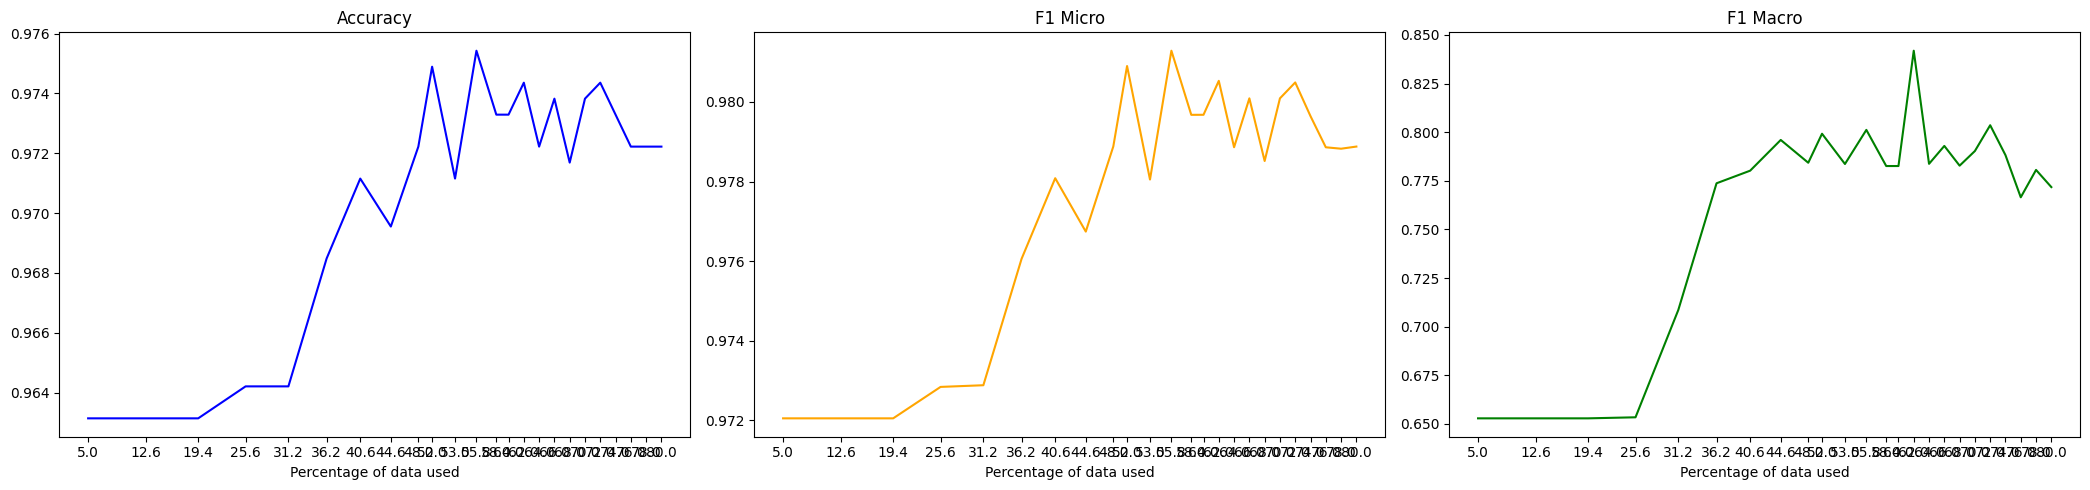

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6098, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3918, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.28, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2134, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2275, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2151, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1362, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5672, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.359, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2512, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2132, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2049, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1265, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5373, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2713, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2123, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2312, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2138, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1374, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5049, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.203, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1661, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1405, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1282, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 9/10, Train Loss: 0.1365, Accuracy: 0.9631, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4524, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1944, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1599, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1661, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1352, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1222, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 9/10, Train Loss: 0.1415, Accuracy: 0.9647, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4546, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2562, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2078, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1681, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.17, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1373, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1356, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 9/10, Train Loss: 0.15, Accuracy: 0.9615, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4334, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2258, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2278, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1738, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1595, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1326, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1253, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.395, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2209, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1662, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.1441, Accuracy: 0.9599, F1 Micro: 0.9688, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1329, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.6558
Epoch 9/10, Train Loss: 0.1214, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2282, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1871, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1661, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1743, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1627, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1366, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.1263, Accuracy: 0.9663, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4066, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1944, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1813, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1845, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1381, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1351, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Epoch 9/10, Train Loss: 0.1022, Accuracy: 0.9679, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3714, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2104, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1915, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1884, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1882, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1396, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 8/10, Train Loss: 0.1436, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1064, Accuracy: 0.9696, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3739, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.221, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1962, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1852, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.194, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1503, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1449, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7228
Epoch 9/10, Train Loss: 0.1048, Accuracy: 0.9679, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3817, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.216, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1804, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7982
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7635
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3509, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2094, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1776, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1521, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2134, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1978, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1904, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1669, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1416, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Epoch 9/10, Train Loss: 0.0821, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3527, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1696, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7664
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7791
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.049, Accuracy: 0.9663, F1 Micro: 0.9745, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3293, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2295, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1687, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.144, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7632
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7774
Epoch 10/10, Train Loss: 0.0527, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3282, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2261, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.18, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1525, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.7223
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.757
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3461, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2139, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1972, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7962
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3229, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2119, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1999, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1714, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7514
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0508, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3261, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2031, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7937
Epoch 10/10, Train Loss: 0.0492, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3366, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1867, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1685, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7187
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7865
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3163, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.9567, F1 Micro: 0.9663, F1 Macro: 0.6473
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7236
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7513
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7893
Epoch 10/10, Train Loss: 0.0475, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3146, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2103, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1861, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.796
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3236, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1525, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7637
Epoch 10/10, Train Loss: 0.039, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3039, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2097, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1698, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 7/10, Train Loss: 0.0822, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.306, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.212, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1683, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7782
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7793
Epoch 10/10, Train Loss: 0.0396, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3249, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1929, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1994, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7962
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.9712, F1 Micro: 0.9781, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3034, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1901, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1593, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7803
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7864
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7989
Epoch 10/10, Train Loss: 0.0412, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3054, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1937, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2055, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.174, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.04

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3083, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2098, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7209
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7559
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7644
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7644
Model 1 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2848, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2098, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7681
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Epoch 10/10, Train Loss: 0.0298, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2935, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2094, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7552
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0341, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2993, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1887, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 7/10, Train Loss: 0.0531, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.801
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0315, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0267, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.284, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1869, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.7895
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9712, F1 Micro: 0.9781, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2873, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1867, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1734, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7971
Epoch 7/10, Train Loss: 0.0581, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7937
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7886
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7884
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.9728, F1 Micro: 0.9792, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2935, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1991, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7886
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9744, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2811, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2019, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7656
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.279, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7461
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2832, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1923, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8002
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Epoch 7/10, Train Loss: 0.0572, Accuracy: 0.9679, F1 Micro: 0.9752, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0443, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2689, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.191, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8227
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7611
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7595
Model 2 - Iteration 300:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2705, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.193, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7971
Epoch 7/10, Train Loss: 0.0605, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.0447, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7971
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9663, F1 Micro: 0.9745, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2639, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1949, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9615, F1 Micro: 0.9701, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 7/10, Train Loss: 0.0546, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0271, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2511, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1937, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7662
Model 2 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.799
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.798
Epoch 10/10, Train Loss: 0.0262, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2736, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1845, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7992
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0625, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.022, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2568, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1828, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 4/10, Train Loss: 0.1412, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7782
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7236
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0226, Accuracy: 0.9679, F1 Micro: 0.9757, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2591, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1827, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7962
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7556
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7441
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.022, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2847, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1709, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7799
Epoch 6/10, Train Loss: 0.0715, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7881
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1847, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Epoch 6/10, Train Loss: 0.07, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0558, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.026, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Model 2 - Iteration 330: Accuracy: 0.9712, F1 Micro: 0.978

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2741, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7541
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7936
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7971
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9535, F1 Micro: 0.9648, F1 Macro: 0.7303
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2595, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1727, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1456, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1261, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.7906
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0626, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Epoch 7/10, Train Loss: 0.0479, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7494
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7819
Epoch 10/10, Train Loss: 0.022, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2461, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1695, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1415, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1242, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1078, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 6/10, Train Loss: 0.0687, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7552
Epoch 7/10, Train Loss: 0.0476, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7338
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7393
Epoch 10/10, Train Loss: 0.0223, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7236
Model 2 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2489, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1484, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1363, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7929
Epoch 6/10, Train Loss: 0.0742, Accuracy: 0.9583, F1 Micro: 0.9688, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0544, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7763
Epoch 8/10, Train Loss: 0.0385, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7951
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1725, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1528, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1301, Accuracy: 0.9615, F1 Micro: 0.9712, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.0696, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Epoch 7/10, Train Loss: 0.0461, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7573
Epoch 8/10, Train Loss: 0.035, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7585
Epoch 9/10, Train Loss: 0.024, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7573
Epoch 10/10, Train Loss: 0.0263, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7469
Model 1 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2465, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 3/10, Train Loss: 0.151, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1285, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1048, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0728, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0476, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.0228, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 10/10, Train Loss: 0.0254, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Model 2 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2482, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1577, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7265
Epoch 8/10, Train Loss: 0.034, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7981
Epoch 10/10, Train Loss: 0.0268, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2681, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1662, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 5/10, Train Loss: 0.0856, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 6/10, Train Loss: 0.0712, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 7/10, Train Loss: 0.0504, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0286, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Epoch 10/10, Train Loss: 0.0264, Accuracy: 0.9679, F1 Micro: 0.9757, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2485, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.164, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0864, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.0759, Accuracy: 0.9567, F1 Micro: 0.9669, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0529, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0321, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7458
Epoch 9/10, Train Loss: 0.0332, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 10/10, Train Loss: 0.0289, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2521, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1664, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1611, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.0774, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7428
Epoch 7/10, Train Loss: 0.0571, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0333, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7502
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0243, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2503, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1714, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1546, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1189, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7505
Epoch 5/10, Train Loss: 0.1012, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0753, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7681
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.75
Epoch 8/10, Train Loss: 0.0359, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8236
Epoch 10/10, Train Loss: 0.0203, Accuracy: 0.9728, F1 Micro: 0.9793, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2358, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1696, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1497, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1171, Accuracy: 0.9599, F1 Micro: 0.97, F1 Macro: 0.7302
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0996, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0514, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0315, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Epoch 10/10, Train Loss: 0.0203, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7567
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2379, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1718, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1305, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 5/10, Train Loss: 0.1099, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.0769, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0512, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.78
Epoch 10/10, Train Loss: 0.0207, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Model 3 - Iteration 370: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2573, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1497, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1396, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1294, Accuracy: 0.9615, F1 Micro: 0.9712, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0937, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0693, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0452, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8031
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8031
Epoch 10/10, Train Loss: 0.0253, Accuracy: 0.9696, F1 Micro: 0.9767, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2428, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1465, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1382, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.138, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7228
Epoch 5/10, Train Loss: 0.099, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0469, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2444, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1498, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1089, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0738, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 7/10, Train Loss: 0.0481, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7977
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7549
Epoch 10/10, Train Loss: 0.0262, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2491, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.165, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1426, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1247, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.744
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0667, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0375, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7458
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0288, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2362, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1626, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1405, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 4/10, Train Loss: 0.1169, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0855, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0626, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0364, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.73
Epoch 8/10, Train Loss: 0.0306, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.744
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.024, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2398, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1628, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1449, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7312
Epoch 7/10, Train Loss: 0.0424, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7491
Epoch 8/10, Train Loss: 0.0351, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7495
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8437
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.9615, F1 Micro: 0.9708, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2488, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1752, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1331, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1288, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Epoch 5/10, Train Loss: 0.0958, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7929
Epoch 6/10, Train Loss: 0.0575, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0468, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0333, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0204, Accuracy: 0.9647, F1 Micro: 0.9734, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2342, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.174, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1335, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 4/10, Train Loss: 0.1323, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1032, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 8/10, Train Loss: 0.0397, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0292, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.022, Accuracy: 0.9679, F1 Micro: 0.9757, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2413, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1761, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1412, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1348, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0595, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.0349, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7788
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7608
Epoch 10/10, Train Loss: 0.0182, Accuracy: 0.9679, F1 Micro: 0.9756, F1 

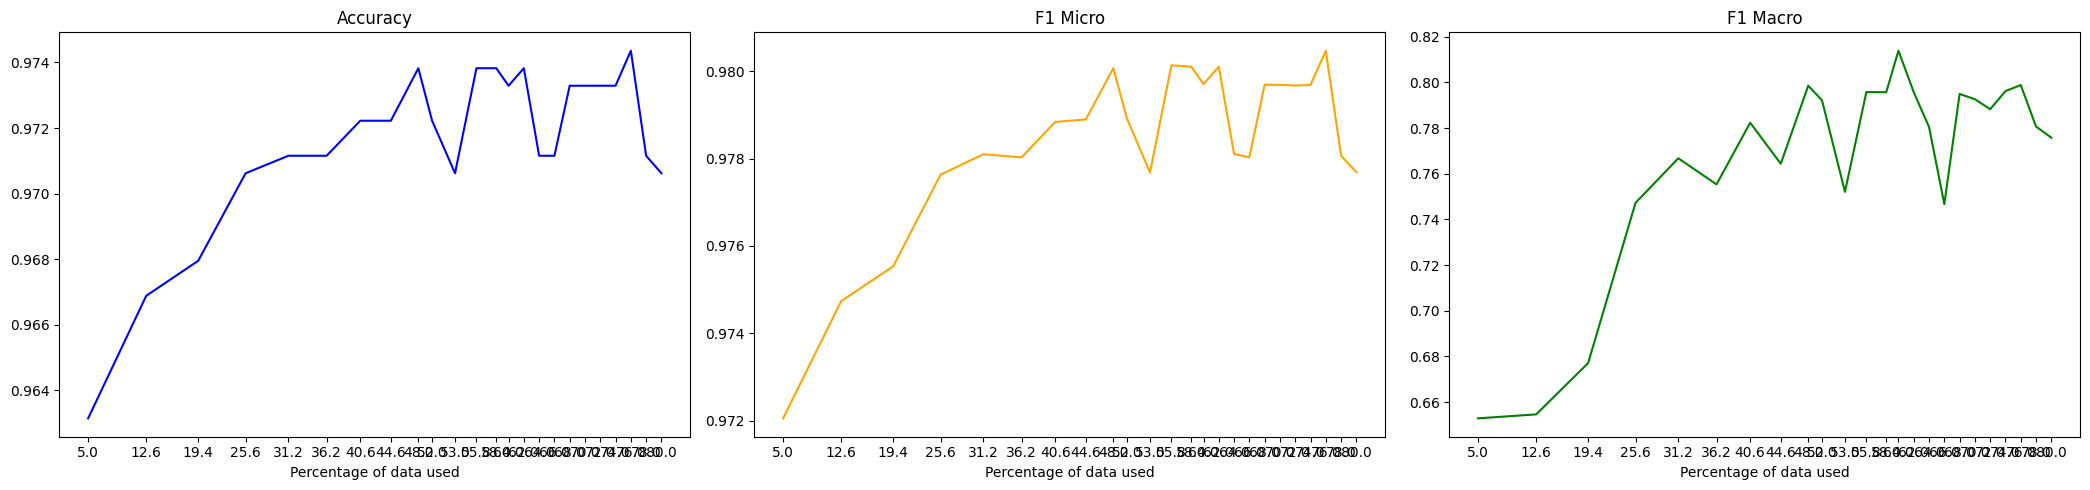

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 7, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5339, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3609, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2079, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2245, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1625, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2034, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1394, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6345, Accuracy: 0.9247, F1 Micro: 0.9395, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3936, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2767, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2144, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2256, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.161, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2104, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1331, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.535, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3536, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.265, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2017, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2273, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1566, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2122, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1355, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2758, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2329, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1592, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1628, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1312, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1511, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2872, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.238, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1279, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1595, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4304, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2342, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1633, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.133, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2032, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1628, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.144, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4259, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2049, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1624, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1422, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2015, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1518, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1218, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1966, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1577, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1463, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 7/10, Train Loss: 0.1195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6523
Epoch 10/10, Train Loss: 0.0679, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4108, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2004, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1545, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1474, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1343, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1107, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6549
Epoch 9/10, Train Loss: 0.0966, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7211
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3623, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1989, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.16, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1619, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1408, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.1151, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1083, Accuracy: 0.9663, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3443, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1883, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.1293, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 10/10, Train Loss: 0.051, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.376, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2208, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1708, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.142, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1281, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8034
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9696, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3316, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1752, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1942, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.18, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1622, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.6494
Epoch 8/10, Train Loss: 0.1122, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.649
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2972, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.174, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 6/10, Train Loss: 0.1116, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.6471
Epoch 7/10, Train Loss: 0.1042, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.648
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.702
Epoch 10/10, Train Loss: 0.0441, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3234, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1707, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1836, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7323
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7823
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2855, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1745, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1334, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7633
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.9583, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2976, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1792, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6998
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.9551, F1 Micro: 0.9654, F1 Macro: 0.649
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Epoch 10/10, Train Loss: 0.037, Accuracy: 0.9663, F1 Micro: 0.9744, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3235, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9615, F1 Micro: 0.9712, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0425, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7876
Epoch 10/10, Train Loss: 0.0313, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.29, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1778, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.186, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9567, F1 Micro: 0.9666, F1 Macro: 0.7035
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0388, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3051, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1817, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9327, F1 Micro: 0.9468, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9567, F1 Micro: 0.9669, F1 Macro: 0.7167
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7642
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3244, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.764
Epoch 5/10, Train Loss: 0.1058, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.8013
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9519, F1 Micro: 0.9636, F1 Macro: 0.7221
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8197
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8209
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3016, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1813, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1612, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9503, F1 Micro: 0.9626, F1 Macro: 0.7189
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2982, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1837, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1725, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1421, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7628
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7211
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3178, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1812, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1703, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1405, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7501
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2911, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1847, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7976
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 10/10, Train Loss: 0.0277, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7196
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2947, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1924, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1678, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7887
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9615, F1 Micro: 0.9701, F1 Macro: 0.7902
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7832
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7439
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2669, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1923, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1628, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7597
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7904
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9487, F1 Micro: 0.9603, F1 Macro: 0.7532
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0306, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2923, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1921, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.171, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.7031
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7655
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7977
Epoch 10/10, Train Loss: 0.035, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.308, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1903, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1281, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 5/10, Train Loss: 0.0997, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7439
Epoch 7/10, Train Loss: 0.0569, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7937
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7583
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Model 2 - Iteration 2

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2872, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1934, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7876
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0338, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2906, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0565, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.306, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1829, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Epoch 6/10, Train Loss: 0.0824, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.749
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7418
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.8029
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0324, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2821, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1823, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1779, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.7587
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7533
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7936
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7618
Epoch 10/10, Train Loss: 0.0366, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7419
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2837, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1933, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1867, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7976
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7978
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7967
Epoch 10/10, Train Loss: 0.0298, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2988, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1933, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9728, F1 Micro: 0.979, F1 Macro: 0.7975
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7956
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7526
Epoch 10/10, Train Loss: 0.0402, Accuracy: 0.9679, F1 Micro: 0.9757, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2766, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1938, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7189
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7929
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7927
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7939
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7959
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9631, F1 Micro: 0.9721, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2832, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1937, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7374
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2991, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.194, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1243, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.7895
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0988, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 6/10, Train Loss: 0.0824, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8031
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7556
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8012
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9631, F1 Micro: 0.9715, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2797, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1948, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7597
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.8134
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2798, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1967, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7375
Epoch 10/10, Train Loss: 0.0327, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2923, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1967, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1335, Accuracy: 0.9744, F1 Micro: 0.9806, F1 Macro: 0.7903
Epoch 5/10, Train Loss: 0.0942, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 6/10, Train Loss: 0.0787, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2726, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1964, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7503
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7479
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 10/10, Train Loss: 0.0299, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2919, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2024, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.755
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3067, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1989, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1371, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7773
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8207
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.976, F1 Micro: 0.9818, F1 Macro: 0.7912
Epoch 10/10, Train Loss: 0.0342, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2839, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2013, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.7893
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7977
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.744
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2577, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2153, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0522, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0416, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.274, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2103, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1527, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1264, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7941
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.101, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7751
Epoch 10/10, Train Loss: 0.0268, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2525, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2129, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1638, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7568
Epoch 7/10, Train Loss: 0.0573, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7451
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7451
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0262, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.242, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1909, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1635, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9744, F1 Micro: 0.9806, F1 Macro: 0.7903
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.9744, F1 Micro: 0.9806, F1 Macro: 0.7903
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.8313
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2568, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1884, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1516, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1227, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.782
Epoch 5/10, Train Loss: 0.0968, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 6/10, Train Loss: 0.0787, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7573
Model 2 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2391, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1909, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7779
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7449
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7383
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9647, F1 Micro: 0.9729, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2613, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1875, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1831, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1351, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1047, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7553
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.787
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2731, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1837, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1127, Accuracy: 0.976, F1 Micro: 0.9818, F1 Macro: 0.8051
Epoch 5/10, Train Loss: 0.0902, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7555
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.749
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.769
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7467
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7521
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7558
Model 2 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.253, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1875, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.774
Epoch 6/10, Train Loss: 0.0717, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7354
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9615, F1 Micro: 0.9706, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2541, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1835, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0804, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.976, F1 Micro: 0.9816, F1 Macro: 0.8225
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 10/10, Train Loss: 0.0283, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1828, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1326, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.0993, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7415
Epoch 6/10, Train Loss: 0.0784, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.0313, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2476, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1833, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9567, F1 Micro: 0.9668, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 7/10, Train Loss: 0.0558, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7709
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7864
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.9712, F1 Micro: 0.978, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2433, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1539, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1341, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7795
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8033
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2574, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1806, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1475, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1125, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0938, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0739, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0465, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7569
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7448
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7483
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9679, F1 Micro: 0.9757, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2399, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1808, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7664
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.0452, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7584
Epoch 10/10, Train Loss: 0.0267, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7446
Model 3 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2387, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1734, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9567, F1 Micro: 0.9664, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0941, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.774
Epoch 7/10, Train Loss: 0.0458, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7877
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7461
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0224, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2515, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7673
Epoch 4/10, Train Loss: 0.1135, Accuracy: 0.9679, F1 Micro: 0.9752, F1 Macro: 0.8172
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0837, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7774
Epoch 6/10, Train Loss: 0.0691, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0471, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7446
Epoch 8/10, Train Loss: 0.037, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7769
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7565
Epoch 10/10, Train Loss: 0.0225, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Model 2 - Iteration 38

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2365, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1764, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1489, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1029, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7379
Epoch 6/10, Train Loss: 0.0763, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7502
Epoch 7/10, Train Loss: 0.0482, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7501
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0223, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.233, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1489, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1133, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7331
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0966, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0635, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 7/10, Train Loss: 0.0513, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.801
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.024, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0216, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2434, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7448
Epoch 5/10, Train Loss: 0.0893, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoch 6/10, Train Loss: 0.0595, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7448
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7927
Epoch 8/10, Train Loss: 0.0384, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7393
Epoch 9/10, Train Loss: 0.0304, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0244, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7769
Model 2 - Iteration 390:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.228, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1609, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.121, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7774
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7946
Epoch 6/10, Train Loss: 0.0709, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7927
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7513
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.765
Epoch 10/10, Train Loss: 0.023, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Model 3 - Iteration 390

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2268, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1699, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1384, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.0967, Accuracy: 0.9519, F1 Micro: 0.9622, F1 Macro: 0.709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0697, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0388, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0353, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2422, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1666, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1374, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1155, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 5/10, Train Loss: 0.0793, Accuracy: 0.9519, F1 Micro: 0.9627, F1 Macro: 0.7549
Epoch 6/10, Train Loss: 0.0676, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0394, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7491
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.755
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0208, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7502
Model 2 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2224, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1416, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.787
Epoch 5/10, Train Loss: 0.095, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0744, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 7/10, Train Loss: 0.04, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7484
Epoch 8/10, Train Loss: 0.037, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7538
Epoch 10/10, Train Loss: 0.019, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro

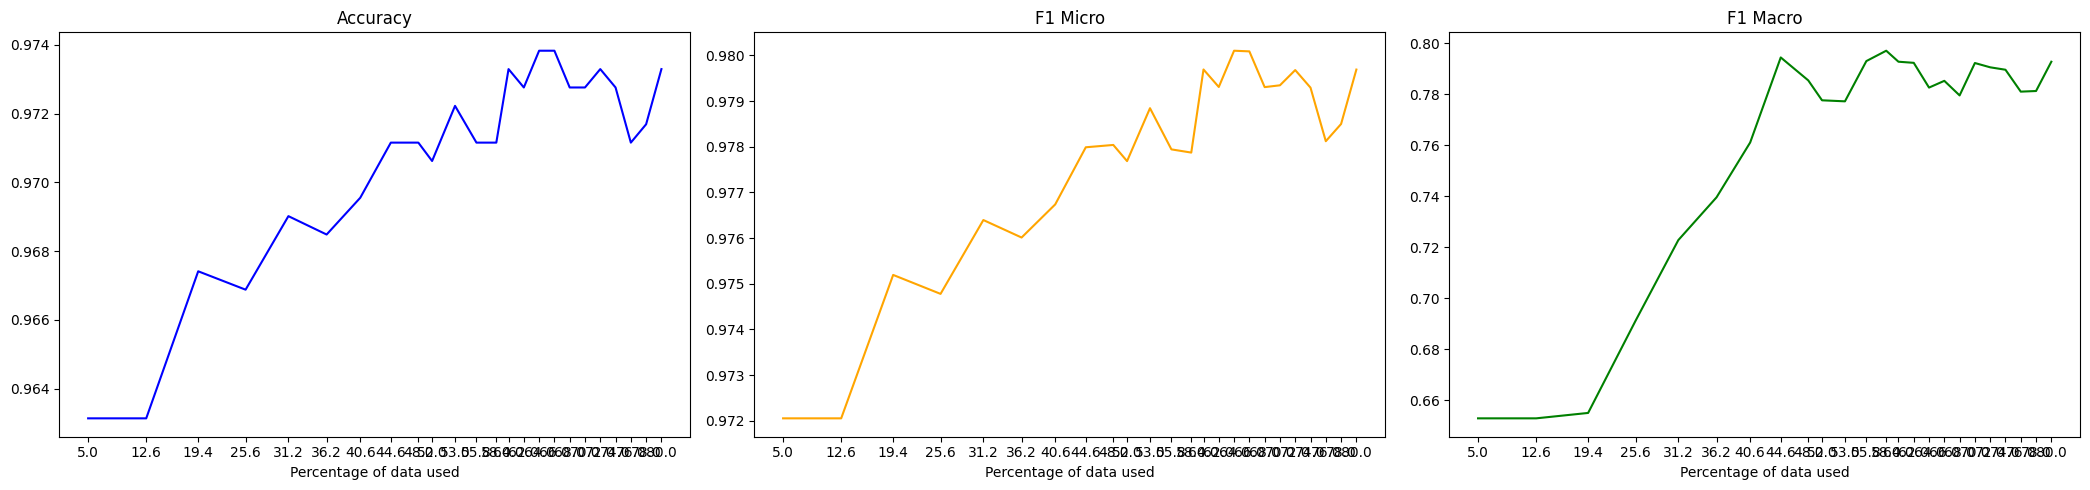

In [20]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5266, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3356, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3008, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2329, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3085, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2216, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2113, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5975, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3447, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3028, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2258, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2719, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2902, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2063, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5206, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3234, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2841, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2164, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2098, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.1935, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Epoch 9/10, Train Loss: 0.1852, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6501
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4236, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2259, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1856, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1473, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4539, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1735, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1567, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1489, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2188, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1713, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1393, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3505, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2459, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1944, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1726, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1316, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1337, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2494, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2214, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1944, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1668, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1714, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1327, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1249, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3397, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1463, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1235, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.1104, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9631, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.348, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.211, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1308, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1202, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.702
Epoch 9/10, Train Loss: 0.0902, Accuracy: 0.9631, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2107, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1699, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.1281, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 8/10, Train Loss: 0.1131, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7226
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3388, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2067, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Epoch 7/10, Train Loss: 0.1223, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1055, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0818, Accuracy: 0.9663, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3379, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1603, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.13, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.648
Epoch 10/10, Train Loss: 0.0591, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2251, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1696, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9728, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3381, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2234, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1652, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7377
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 10/10, Train Loss: 0.0565, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3143, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1888, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1385, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9503, F1 Micro: 0.9613, F1 Macro: 0.6443
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9696, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3283, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7209
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9696, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3071, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1913, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7495
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7483
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7496
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2923, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1774, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9599, F1 Micro: 0.9699, F1 Macro: 0.7306
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3111, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1783, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7369
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7794
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9679, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2897, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1822, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7655
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7197
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7376
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7377
Epoch 10/10, Train Loss: 0.0412, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3061, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1984, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1828, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.764
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8023
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.7528
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.8087
Epoch 10/10, Train Loss: 0.0356, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3193, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1993, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1884, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7627
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Epoch 10/10, Train Loss: 0.0394, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3016, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1983, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7144
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7654
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7654
Model 3 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3021, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2043, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7361
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7401
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.9615, F1 Micro: 0.9708, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3161, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2046, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1671, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7201
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7367
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7964
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3028, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2022, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.9679, F1 Micro: 0.9757, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.287, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2157, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2017, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7538
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7541
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7531
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3028, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2156, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7964
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7794
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.8024
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2856, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7794
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7622
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7552
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7847
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.031, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2789, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.207, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7648
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7747
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7487
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7531
Epoch 10/10, Train Loss: 0.0363, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2884, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2061, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7966
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7976
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9728, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2771, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2044, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7537
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7459
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2843, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1825, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7944
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7539
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7617
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2977, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1834, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7655
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2817, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1824, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7982
Epoch 7/10, Train Loss: 0.0579, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7803
Epoch 8/10, Train Loss: 0.0493, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.03, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2669, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1895, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7625
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0304, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7877
Epoch 10/10, Train Loss: 0.0234, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2801, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1896, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 6/10, Train Loss: 0.0803, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8023
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7875
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.267, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1896, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.171, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7556
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7522
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0238, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7494
Model 3 - Iteration 2

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1975, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.1063, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7632
Epoch 6/10, Train Loss: 0.0808, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7633
Epoch 7/10, Train Loss: 0.0582, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7505
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7942
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2726, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1991, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.72
Epoch 5/10, Train Loss: 0.0977, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7962
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7423
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 10/10, Train Loss: 0.0212, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2601, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1985, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.0972, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.7898
Epoch 6/10, Train Loss: 0.0788, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0336, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2564, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1919, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1751, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0998, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Epoch 6/10, Train Loss: 0.0704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7644
Epoch 7/10, Train Loss: 0.043, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7847
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7625
Epoch 10/10, Train Loss: 0.0255, Accuracy: 0.9679, F1 Micro: 0.9756, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2668, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1918, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Epoch 6/10, Train Loss: 0.0735, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 7/10, Train Loss: 0.0431, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.7966
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2501, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1915, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1367, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0852, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7982
Epoch 6/10, Train Loss: 0.0612, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0391, Accuracy: 0.9776, F1 Micro: 0.983, F1 Macro: 0.8237
Epoch 8/10, Train Loss: 0.0406, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Epoch 9/10, Train Loss: 0.0292, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8189
Epoch 10/10, Train Loss: 0.0251, Accuracy: 0.9631, F1 Micro: 0.9716, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2426, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1713, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.9583, F1 Micro: 0.9688, F1 Macro: 0.7418
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7655
Epoch 6/10, Train Loss: 0.0764, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7855
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7486
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.0215, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.8144
Model 1 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2507, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1694, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.75
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7567
Epoch 10/10, Train Loss: 0.0201, Accuracy: 0.9647, F1 Micro: 0.9733, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2382, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0678, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.776
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.035, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8042
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0204, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2393, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1782, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1386, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9567, F1 Micro: 0.9667, F1 Macro: 0.7589
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7587
Epoch 8/10, Train Loss: 0.0336, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7655
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0194, Accuracy: 0.9615, F1 Micro: 0.9708, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.252, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1787, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1386, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1145, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0809, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7976
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0321, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.8695
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.843
Epoch 10/10, Train Loss: 0.0171, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2392, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.178, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1283, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7795
Epoch 5/10, Train Loss: 0.1086, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7611
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 7/10, Train Loss: 0.0555, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0322, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0297, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0176, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2283, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1834, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1695, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7489
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.0745, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7868
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7867
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0227, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2406, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1831, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1712, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7794
Epoch 8/10, Train Loss: 0.0385, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.8024
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2253, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1846, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7503
Epoch 5/10, Train Loss: 0.0945, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.07, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7774
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2441, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1628, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1494, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 5/10, Train Loss: 0.0903, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7404
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0626, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7646
Epoch 7/10, Train Loss: 0.0418, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7727
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7549
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7636
Epoch 10/10, Train Loss: 0.0243, Accuracy: 0.9631, F1 Micro: 0.9721, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2531, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1612, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1483, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1348, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.0892, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.059, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0365, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0295, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 9/10, Train Loss: 0.0297, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.0235, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2414, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1401, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1193, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0776, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0583, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Epoch 7/10, Train Loss: 0.0387, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 9/10, Train Loss: 0.0323, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1802, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1371, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.0693, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7487
Epoch 7/10, Train Loss: 0.0512, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7477
Epoch 8/10, Train Loss: 0.0339, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8302
Epoch 9/10, Train Loss: 0.0199, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0217, Accuracy: 0.9631, F1 Micro: 0.9723, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2315, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1809, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 6/10, Train Loss: 0.0682, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7494
Epoch 7/10, Train Loss: 0.0531, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0214, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8031
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2176, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1813, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1521, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1279, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1003, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 6/10, Train Loss: 0.0611, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.744
Epoch 7/10, Train Loss: 0.0472, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0336, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7744
Epoch 9/10, Train Loss: 0.0189, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.022, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2304, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1511, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0714, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 7/10, Train Loss: 0.0531, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7502
Epoch 8/10, Train Loss: 0.0405, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7885
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7574
Epoch 10/10, Train Loss: 0.0208, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.238, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1504, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 6/10, Train Loss: 0.0652, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.051, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0384, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7925
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Epoch 10/10, Train Loss: 0.0188, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2274, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1501, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.126, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 7/10, Train Loss: 0.0486, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8022
Epoch 8/10, Train Loss: 0.0357, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 10/10, Train Loss: 0.0181, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2244, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.127, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7383
Epoch 6/10, Train Loss: 0.0671, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7655
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7655
Epoch 10/10, Train Loss: 0.0211, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2327, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1627, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.157, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1197, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 5/10, Train Loss: 0.1112, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.062, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7764
Epoch 7/10, Train Loss: 0.0496, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0375, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.7965
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8023
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.226, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1627, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1074, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7937
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7419
Epoch 6/10, Train Loss: 0.0566, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0443, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7468
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7576
Epoch 9/10, Train Loss: 0.0259, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0206, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1579, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1295, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7449
Epoch 6/10, Train Loss: 0.0735, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7444
Epoch 7/10, Train Loss: 0.0429, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7487
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7495
Epoch 10/10, Train Loss: 0.0191, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7484
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2375, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1566, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1273, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1039, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0694, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0437, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.022, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2268, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1599, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 4/10, Train Loss: 0.1172, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7177
Epoch 5/10, Train Loss: 0.0883, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0618, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 7/10, Train Loss: 0.042, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.747
Epoch 8/10, Train Loss: 0.0281, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7431
Epoch 9/10, Train Loss: 0.0246, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7394
Epoch 10/10, Train Loss: 0.0181, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Model 3 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2119, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1575, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1598, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0896, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.746
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0508, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0343, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0248, Accuracy: 0.9679, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2191, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1586, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1522, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0856, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0452, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 8/10, Train Loss: 0.0364, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7123
Epoch 10/10, Train Loss: 0.0237, Accuracy: 0.9728, F1 Micro: 0.9791, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2072, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1271, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.075, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 6/10, Train Loss: 0.061, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7494
Epoch 7/10, Train Loss: 0.0423, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0314, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0236, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0191, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Model 3 - Iteration 4

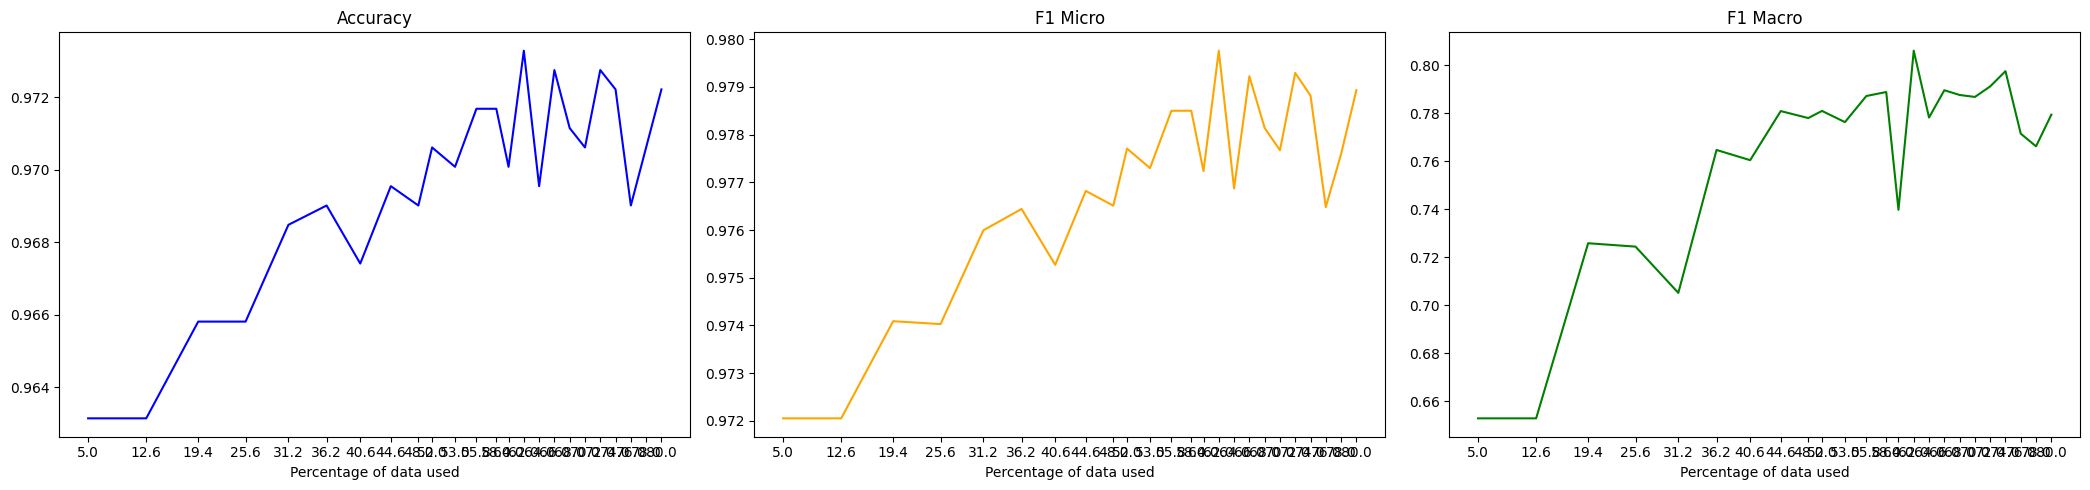

In [21]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2173, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1465, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2033, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.128, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5508, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3494, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2433, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1288, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5872, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2613, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2079, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.226, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1624, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1384, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2016, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1772, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1606, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1204, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4421, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2219, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1593, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1241, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4735, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1791, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1672, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1274, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1163, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.0908, Accuracy: 0.9615, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3555, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2164, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1387, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9519, F1 Micro: 0.9629, F1 Macro: 0.6453
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9359, F1 Micro: 0.9497, F1 Macro: 0.6337
Epoch 9/10, Train Loss: 0.0835, Accuracy: 0.9407, F1 Micro: 0.9538, F1 Macro: 0.6376
Epoch 10/10, Train Loss: 0.078, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.386, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2329, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1315, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.1213, Accuracy: 0.9567, F1 Micro: 0.9664, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0936, Accuracy: 0.9679, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3491, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1629, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.145, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Epoch 8/10, Train Loss: 0.142, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1089, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3299, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1947, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1421, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1262, Accuracy: 0.9567, F1 Micro: 0.9669, F1 Macro: 0.6487
Epoch 8/10, Train Loss: 0.1373, Accuracy: 0.9471, F1 Micro: 0.9591, F1 Macro: 0.6423
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0973, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2081, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1447, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1282, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1366, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.0985, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3544, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.209, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1229, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6517
Epoch 10/10, Train Loss: 0.0615, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3463, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2075, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1692, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.14, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.1299, Accuracy: 0.9567, F1 Micro: 0.9666, F1 Macro: 0.6482
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 10/10, Train Loss: 0.057, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3637, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2178, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1731, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.1287, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7027
Epoch 10/10, Train Loss: 0.0628, Accuracy: 0.9647, F1 Micro: 0.9732, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.317, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1943, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1883, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1812, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1536, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.6492
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6514
Epoch 10/10, Train Loss: 0.0574, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3046, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1964, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1848, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1551, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.1259, Accuracy: 0.9535, F1 Micro: 0.9641, F1 Macro: 0.6461
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.9503, F1 Micro: 0.9615, F1 Macro: 0.644
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Epoch 10/10, Train Loss: 0.0556, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3262, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1988, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.178, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1521, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.6471
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9567, F1 Micro: 0.9666, F1 Macro: 0.6482
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7008
Epoch 10/10, Train Loss: 0.0699, Accuracy: 0.9663, F1 Micro: 0.9743, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3062, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2082, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1837, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1683, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1628, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.6502
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 10/10, Train Loss: 0.0544, Accuracy: 0.9647, F1 Micro: 0.973, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3016, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2078, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2233, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 6/10, Train Loss: 0.1551, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.6492
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.9567, F1 Micro: 0.9666, F1 Macro: 0.6482
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9503, F1 Micro: 0.9614, F1 Macro: 0.6437
Epoch 10/10, Train Loss: 0.052, Accuracy: 0.9631, F1 Micro: 0.9718, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3139, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1692, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.1652, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.1059, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 10/10, Train Loss: 0.0614, Accuracy: 0.9679, F1 Micro: 0.9755, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2966, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9535, F1 Micro: 0.9641, F1 Macro: 0.6461
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6882
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 10/10, Train Loss: 0.0475, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2887, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1676, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6514
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6523
Epoch 10/10, Train Loss: 0.0564, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3035, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1746, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1613, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.1257, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7019
Epoch 10/10, Train Loss: 0.0642, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2892, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1982, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1897, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6968
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7198
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7495
Epoch 10/10, Train Loss: 0.0403, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1971, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9712, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2961, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2001, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7226
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2951, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1924, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1655, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1193, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0276, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2898, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.191, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1645, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9567, F1 Micro: 0.9666, F1 Macro: 0.6482
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7192
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6523
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9503, F1 Micro: 0.9615, F1 Macro: 0.7268
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.9663, F1 Micro: 0.9743, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3034, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1976, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1695, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0356, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2796, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.187, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7314
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7886
Epoch 10/10, Train Loss: 0.033, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2742, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1897, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9535, F1 Micro: 0.9639, F1 Macro: 0.6456
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.7896
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7187
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7622
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.767
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2836, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1918, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9615, F1 Micro: 0.97, F1 Macro: 0.6502
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7402
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7512
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0434, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2827, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9631, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2752, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1974, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2911, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.201, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1117, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.764
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1894, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7194
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8002
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2702, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1864, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9696, F1 Micro: 0.9768, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2831, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1911, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9744, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2564, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.184, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1869, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7286
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7834
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0254, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2519, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1832, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8031
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8022
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2644, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1873, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1791, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.113, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7478
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8207
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.976, F1 Micro: 0.9816, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1902, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1913, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7937
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7978
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2888, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1929, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7574
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7788
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0443, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.25, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1957, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1624, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1056, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.784
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7483
Epoch 8/10, Train Loss: 0.0441, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7886
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9663, F1 Micro: 0.9746, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2459, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1941, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1629, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7622
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8033
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2584, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1992, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.7891
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2541, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1777, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.8035
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2521, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1795, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1772, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8022
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 8/10, Train Loss: 0.0484, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.265, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1797, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7471
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2459, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1876, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1777, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7211
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7167
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7473
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.757
Epoch 10/10, Train Loss: 0.0245, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2456, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1893, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7673
Epoch 7/10, Train Loss: 0.0528, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.976, F1 Micro: 0.9816, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.254, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1915, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2564, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1089, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7793
Epoch 6/10, Train Loss: 0.0773, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7579
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0315, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Epoch 10/10, Train Loss: 0.0233, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2497, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1901, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1587, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0793, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7977
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1632, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1371, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8033
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2517, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1931, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1598, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0698, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.049, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0365, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Epoch 10/10, Train Loss: 0.0245, Accuracy: 0.9663, F1 Micro: 0.9744, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2478, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1923, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1388, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0765, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0538, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Epoch 8/10, Train Loss: 0.039, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7512
Epoch 10/10, Train Loss: 0.025, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1645, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0768, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0525, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9679, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2316, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1671, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7028
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0934, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0668, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7495
Epoch 8/10, Train Loss: 0.0295, Accuracy: 0.9567, F1 Micro: 0.9676, F1 Macro: 0.7433
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7663
Epoch 10/10, Train Loss: 0.0212, Accuracy: 0.9663, F1 Micro: 0.9746, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2286, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 5/10, Train Loss: 0.097, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 6/10, Train Loss: 0.0608, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 7/10, Train Loss: 0.0508, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.744
Epoch 8/10, Train Loss: 0.0318, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8218
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2359, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1031, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 6/10, Train Loss: 0.0759, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.7966
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.767
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2458, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1562, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1355, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0697, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7877
Epoch 8/10, Train Loss: 0.0403, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2401, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1573, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 6/10, Train Loss: 0.0698, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7514
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7632
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 10/10, Train Loss: 0.0197, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.251, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1592, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.6569
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.7966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0796, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0421, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0311, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0186, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2324, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1489, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1461, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 4/10, Train Loss: 0.1328, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.702
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7579
Epoch 6/10, Train Loss: 0.0684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7438
Epoch 7/10, Train Loss: 0.0457, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7282
Epoch 8/10, Train Loss: 0.0329, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0258, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0217, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2322, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1501, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1466, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1245, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7237
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1041, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 6/10, Train Loss: 0.0686, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.044, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.775
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 10/10, Train Loss: 0.0211, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2407, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1541, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.152, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0821, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0509, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7902
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.754
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.023, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2335, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.16, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1392, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1322, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1025, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.0641, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0466, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Epoch 8/10, Train Loss: 0.0349, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0195, Accuracy: 0.9679, F1 Micro: 0.9757, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2294, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1411, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1334, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1012, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0669, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 7/10, Train Loss: 0.0524, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7854
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7936
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7864
Epoch 10/10, Train Loss: 0.0226, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2385, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1616, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1422, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0756, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7901
Epoch 8/10, Train Loss: 0.0397, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch

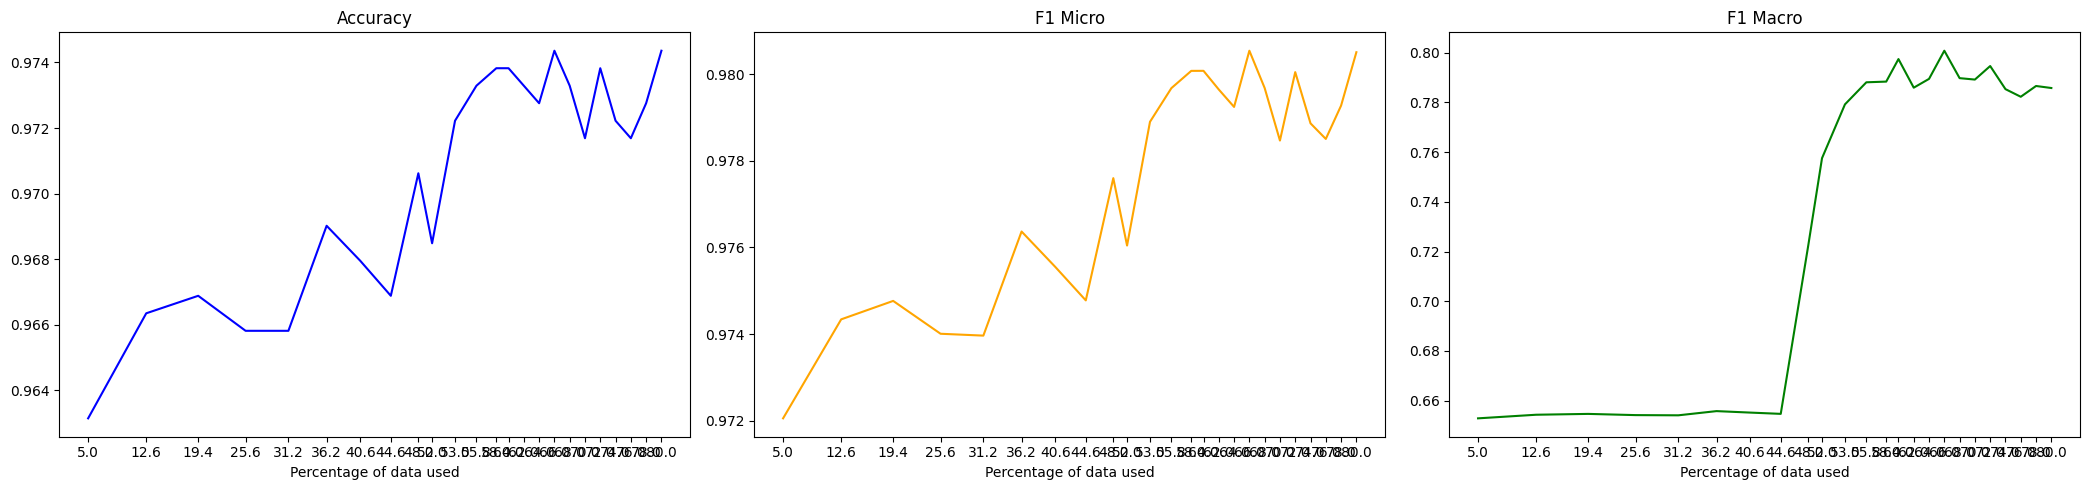

In [ ]:
active_learning(seeds[4], 4)